#### Importing Libraries

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split 

#### Reading the data

In [3]:
root_data_dir = "/content/drive/MyDrive/IIT-J/Semester1/Assignments/ML/Assignment-Fractal3/Q3_ChartImageClassification/data/charts/"
df = pd.read_csv(root_data_dir+"train_val.csv")

In [4]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["type"].values, random_state=0
)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df["type"])
le.classes_

array(['dot_line', 'hbar_categorical', 'line', 'pie', 'vbar_categorical'],
      dtype=object)

In [6]:
train_df["encoded_type"] = le.transform(train_df["type"])
val_df["encoded_type"] = le.transform(val_df["type"])

In [14]:
import os

base_path = "charts"
train_df["image_path"] = train_df["image_index"].apply(
    lambda x: os.path.join(root_data_dir, "train_val", f"{str(x)}.png")
)
val_df["image_path"] = val_df["image_index"].apply(
    lambda x: os.path.join(root_data_dir, "train_val", f"{str(x)}.png")
)

In [15]:
train_df.head()

,image_index,type,encoded_type,image_path
327,327,hbar_categorical,1,/content/drive/MyDrive/IIT-J/Semester1/Assignm...
205,205,hbar_categorical,1,/content/drive/MyDrive/IIT-J/Semester1/Assignm...
136,136,vbar_categorical,4,/content/drive/MyDrive/IIT-J/Semester1/Assignm...
179,179,vbar_categorical,4,/content/drive/MyDrive/IIT-J/Semester1/Assignm...
533,533,line,2,/content/drive/MyDrive/IIT-J/Semester1/Assignm...


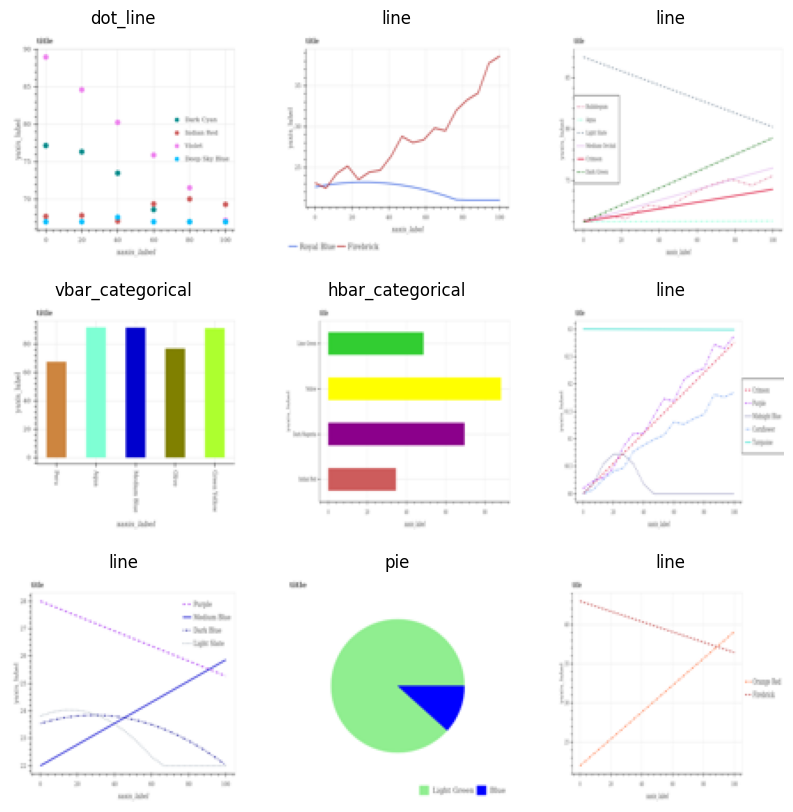

In [16]:
import matplotlib.pyplot as plt 
import numpy as np
import PIL

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(train_df.sample(9).iterrows()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(PIL.Image.open(row["image_path"])))
    plt.title(row["type"])
    plt.axis("off")

In [17]:
import tensorflow as tf 
tf.keras.utils.set_random_seed(0)

BATCH_SIZE = 128

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3) 
    return image, label

def create_dataset(dataframe, val=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["image_path"], dataframe["encoded_type"])
    )
    if not val:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [18]:
train_dataset = create_dataset(train_df)
validation_dataset = create_dataset(val_df, val=True)
train_dataset.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [23]:
from tensorflow import keras 

inputs = keras.Input((128, 128, 3))
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False
) 
base_model.trainable = False 

# We unfreeze some of the layers in the base model which is are fine-tuning.
# for layer in base_model.layers[-20:]:
#     if not isinstance(layer, keras.layers.BatchNormalization):
#         layer.trainable = True
 
x = keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(len(le.classes_), activation="softmax")(x)
charts_model = keras.Model(inputs, outputs)

charts_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [24]:
charts_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"], 
    optimizer=keras.optimizers.Adam(1e-4)
)
history = charts_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
)

Epoch 1/10
13/13 [==============================] - 3s 110ms/step - loss: 9.2209 - accuracy: 0.1975 - val_loss: 7.0607 - val_accuracy: 0.1850
Epoch 2/10
13/13 [==============================] - 1s 90ms/step - loss: 7.9772 - accuracy: 0.2275 - val_loss: 6.0928 - val_accuracy: 0.1900
Epoch 3/10
13/13 [==============================] - 1s 90ms/step - loss: 7.3113 - accuracy: 0.2313 - val_loss: 5.2489 - val_accuracy: 0.2350
Epoch 4/10
13/13 [==============================] - 1s 90ms/step - loss: 6.3424 - accuracy: 0.2775 - val_loss: 4.5384 - val_accuracy: 0.2800
Epoch 5/10
13/13 [==============================] - 1s 90ms/step - loss: 6.1280 - accuracy: 0.2663 - val_loss: 3.9401 - val_accuracy: 0.3250
Epoch 6/10
13/13 [==============================] - 1s 90ms/step - loss: 5.3839 - accuracy: 0.2988 - val_loss: 3.4469 - val_accuracy: 0.3800
Epoch 7/10
13/13 [==============================] - 1s 90ms/step - loss: 5.5191 - accuracy: 0.3000 - val_loss: 3.0115 - val_accuracy: 0.4200
Epoch 8/10
1

In [25]:
# We unfreeze some of the layers in the base model which is are fine-tuning.
for layer in charts_model.layers[-10:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

In [26]:
history = charts_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100
13/13 [==============================] - 1s 100ms/step - loss: 4.0313 - accuracy: 0.3988 - val_loss: 1.8820 - val_accuracy: 0.5450
Epoch 2/100
13/13 [==============================] - 1s 91ms/step - loss: 3.8045 - accuracy: 0.4075 - val_loss: 1.6756 - val_accuracy: 0.5950
Epoch 3/100
13/13 [==============================] - 1s 90ms/step - loss: 3.4050 - accuracy: 0.4650 - val_loss: 1.4971 - val_accuracy: 0.6650
Epoch 4/100
13/13 [==============================] - 1s 91ms/step - loss: 3.0732 - accuracy: 0.4638 - val_loss: 1.3405 - val_accuracy: 0.6900
Epoch 5/100
13/13 [==============================] - 1s 90ms/step - loss: 2.7886 - accuracy: 0.4900 - val_loss: 1.1987 - val_accuracy: 0.7100
Epoch 6/100
13/13 [==============================] - 1s 90ms/step - loss: 2.8562 - accuracy: 0.5175 - val_loss: 1.0767 - val_accuracy: 0.7300
Epoch 7/100
13/13 [==============================] - 1s 90ms/step - loss: 2.5574 - accuracy: 0.5450 - val_loss: 0.9671 - val_accuracy: 0.7450
Epoch

In [29]:
import glob 

test_image_paths = sorted(glob.glob(root_data_dir+"test/*.png"))
labels = [0] * len(test_image_paths) # dummy labels for now, don't worry

test_df = pd.DataFrame(
    {"image_path": test_image_paths, "encoded_type": labels}
)
test_df.head()

,image_path,encoded_type
0,/content/drive/MyDrive/IIT-J/Semester1/Assignm...,0
1,/content/drive/MyDrive/IIT-J/Semester1/Assignm...,0
2,/content/drive/MyDrive/IIT-J/Semester1/Assignm...,0
3,/content/drive/MyDrive/IIT-J/Semester1/Assignm...,0
4,/content/drive/MyDrive/IIT-J/Semester1/Assignm...,0


In [30]:
test_dataset = create_dataset(test_df)
test_dataset.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [31]:
image_indices = list(
    map(lambda x: int(x.split("/")[-1].split(".")[0]), test_image_paths)
)
predictions = charts_model.predict(test_dataset)
predictions = predictions.argmax(-1)
types = le.inverse_transform(predictions)

1/1 [==============================] - 7s 7s/step


In [32]:
final_dataframe = pd.DataFrame({
    "image_index": image_indices, "type": types
})
final_dataframe.head()

,image_index,type
0,0,vbar_categorical
1,1,line
2,10,vbar_categorical
3,11,hbar_categorical
4,12,dot_line


In [40]:
import time

timestamp = time.strftime("%Y%m%d_%H%M%S")
final_dataframe.to_csv(f"{timestamp}_test.csv", index=False)

In [41]:
!mv 20230430_093714_test.csv {"/".join(root_data_dir.split("/")[:-3])+"/output/"}predictions.csv